<a href="https://colab.research.google.com/github/Ishwin9/text-prediction/blob/main/Shakespearean_Text_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shakespeare Bot: An NLP Text Prediction Neural Network


## Step 1: Data Collection + Data Cleaning


In [21]:
dataurl = "https://gist.githubusercontent.com/Ishwin9/a79c0a9e6af14e4cf819768d2f560f1a/raw/0df4aff0453895874b2d1300793be3537489ed8f/gistfile1.txt"

In [22]:

from urllib.request import urlopen
data = urlopen(dataurl).read().decode('utf-8').split("\n")
print("Number of monologues: {}".format(len(data)))

unique = set([w for s in data for w in s.split()])
print("Number of unique words: {}".format(len(unique)))

Number of monologues: 639
Number of unique words: 4772


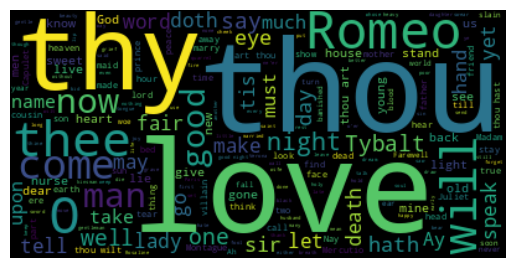

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# get rid of blank lines
data = [line for line in data if line != '']

# plot word cloud to see most ised words
wordcloud = WordCloud().generate(' '.join(data))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Considering the data is the script from the Romeo and Juliet play, it seems fitting that "love" is one of the most used words.

In [ ]:
import spacy

# tokenization
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner", "textcat"])
data = [nlp(s) for s in data]

# adding <n> tag to specify a new monologue
data = [ ["<n>"] + [str(w) for w in s] + ["</n>"] for s in data]

#split into train and validate
train = data[:-5]
valid = data[-5:]

# flatten the lists into one long string and remove extra whitespace
train = [w for s in train for w in s if not w.isspace()]
valid = [w for s in valid for w in s if not w.isspace()]

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
print("Training dataset contains {} lexical types (unique words)".format(len(set(train))))
print("Training dataset contains {} lexical tokens (number of words)".format(len(train)))

Training dataset contains 3247 lexical types (unique words)
Training dataset contains 22039 lexical tokens (number of words)


In [ ]:
import re
def simplify_word(w):
    # remove extra punctuation
    w = w.replace("-", "").replace("~","")

    # replace numbers with # sign
    w = re.sub('\d', '#', w)

    # split words into root and stem
    if len(w) > 3 and w[-2:] in set(["ed", "er","ly"]):
        return [w[:-2], w[-2:]]
    elif len(w) > 4 and w[-3:] in set(["ing","'re"]):
        return [w[:-3], w[-3:]]
    return [w]

In [ ]:
# loop through all the words and perform data cleaning
train_clean = []
for w in train:
    for piece in simplify_word(w):
        train_clean.append(piece)

valid_clean = []
for w in valid:
    for piece in simplify_word(w):
        valid_clean.append(piece)


In [ ]:
from collections import Counter

counts_clean = Counter(train_clean)

# only keeping the tokens in validation set that are already in train
train_new = [w for w in train_clean]
valid_new = [w for w in valid_clean if w in counts_clean]


In [ ]:
# create a mapping from words <-> numbers
vocab = set(train_new)
word_to_num = {}
num_to_word = {}
for num, word in enumerate(vocab):
  word_to_num[word] = num
  num_to_word[num] = word

# convert our dataset tokens into integers
import torch
train = torch.LongTensor(len(train_new))
for i in range(len(train_new)):
  train[i] = word_to_num[train_new[i]]

valid = torch.LongTensor(len(valid_new))
for i in range(len(valid_new)):
  valid[i] = word_to_num[valid_new[i]]

In [ ]:
num_batches = 30
num_tokens_in_batch = 200

# use a GPU for computation
device = torch.device("cuda")

# divide data into `num_batches` batches
def batchify(data, bsz):
    nbatch = data.size(0) // bsz
    data = data.narrow(0, 0, nbatch * bsz)
    data = data.view(bsz, -1).t().contiguous() # reshape
    return data.to(device)

def get_batch(source, i, seq_len):
    seq_len = min(seq_len, len(source) - 1 - i)
    data = source[i:i+seq_len]

    # targets are the same sequce of words but index shifed to the right, i.e. the next word
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

def repackage_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

train = batchify(train, num_batches)
valid = batchify(valid, num_batches)

In [ ]:
import torch.nn as nn

class EncoderDecoder(nn.Module):
  def __init__(self):
    super(EncoderDecoder, self).__init__()
    self.embed_size = 300
    self.hidden_size = 600

    # create embedding matrix, i.e. map each word to vector of ints
    self.embedding = nn.Embedding(len(vocab), self.embed_size)

    # initialize embedding matrix with a random uniform distribution
    initrange = 0.1
    self.embedding.weight.data.uniform_(-initrange, initrange)


    # RNN (LSTM) with dropout
    self.rnn = nn.LSTM(input_size=self.embed_size,
                       hidden_size=self.hidden_size)
    self.shrink = nn.Linear(self.hidden_size,
                            self.embed_size)
    self.drop = nn.Dropout(p=0.5)

    # decode layer predicts next words from our model
    self.decode = nn.Linear(self.embed_size, self.embedding.weight.size(0))
    self.decode.weight = self.embedding.weight
    self.decode.bias.data.zero_()


  def forward(self, input, hidden=None):
    x = self.embedding(input)
    if hidden is not None:
      x, hidden = self.rnn(x, hidden)
    else:
      x, hidden = self.rnn(x)
    x = F.relu(self.shrink(self.drop(x)))
    x = self.decode(x)
    return hidden, x

In [ ]:
import torch.nn.functional as F
def training(model, data, targets, lr, hidden):
  # reset gradient
  model.zero_grad()

  # get prediction
  hidden, prediction_vector = model(data, hidden)
  prediction_vector = prediction_vector.view(targets.size(0), -1)

  # calculate loss
  loss = F.cross_entropy(input = prediction_vector, target = targets)

  # get gradients and perform back-propagation
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
  for p in model.parameters():
      if p.grad is not None:
        p.data.add_(-lr, p.grad.data)

  return loss.item(), repackage_hidden(hidden)

In [ ]:
def validation(model):
 # checks the predictions without updating parameters
  model.eval()
  hidden = None
  valid_loss = 0
  for i in range(0, valid.size(0) - num_tokens_in_batch, num_tokens_in_batch):
    data, targets = get_batch(valid, i, num_tokens_in_batch)
    hidden, prd = model(data, hidden)
    hidden = repackage_hidden(hidden)

    # softmax calculation
    softmax = torch.exp(prd) / torch.exp(prd).sum(dim=1, keepdim=True)

    # cross-entropy loss calculation
    log_softmax = torch.log(softmax)
    loss = -log_softmax[torch.arange(log_softmax.size(0)), targets].sum()
    validation_loss += loss.item()
  return valid_loss / (valid.size(0)/num_tokens_in_batch)

In [ ]:
import numpy as np
import time

model = EncoderDecoder().float().to(device)
prev_valid_loss = 1e100

learning_rate = 20
num_batches = 20

In [ ]:
import time

num_epochs = 150
timing = time.time()

# train specified number of epochs
for epoch in range(num_epochs):

  model.train()
  hidden = None
  train_loss = 0
  start_time = time.time()
  for i in range(0, train.size(0) - 1, num_tokens_in_batch):
    data, targets = get_batch(train, i, num_tokens_in_batch)

    # run the model and perform backpropagation
    loss, hidden = training(model, data, targets, learning_rate, hidden)
    train_loss += loss

  # evaluate how well the model predicts unseen validation data
  valid_loss = validation(model)

# updte learning rate if model is getting worse
  if valid_loss > prev_valid_loss:
    learning_rate /= 4.0

  train_loss /= (train.size(0)/num_tokens_in_batch)
  finish_time = time.time()
  print("Epoch {:2} took {:3.2f}s with train accuracy: {:7.2f}"\
        " and validation: {:7.2f}".format(epoch, finish_time - start_time,
                                          np.exp(train_loss),
                                          np.exp(valid_loss)))

  prev_valid_loss = valid_loss

total_time = (time.time() - timing)/60
print("Completed {} epochs in {:5.3f} minutes".format(num_epochs, total_time))

<ipython-input-12-bbf4e0e731c6>:18: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  p.data.add_(-lr, p.grad.data)


Epoch  0 took 1.25s with train accuracy: 186304.96 and validation:    1.00
Epoch  1 took 0.19s with train accuracy: 28264.41 and validation:    1.00
Epoch  2 took 0.19s with train accuracy: 948389.08 and validation:    1.00
Epoch  3 took 0.19s with train accuracy: 7341.78 and validation:    1.00
Epoch  4 took 0.19s with train accuracy: 8497.49 and validation:    1.00
Epoch  5 took 0.19s with train accuracy: 1693.77 and validation:    1.00
Epoch  6 took 0.19s with train accuracy: 5062.26 and validation:    1.00
Epoch  7 took 0.19s with train accuracy: 1234.88 and validation:    1.00
Epoch  8 took 0.19s with train accuracy: 1530.73 and validation:    1.00
Epoch  9 took 0.19s with train accuracy: 3222.08 and validation:    1.00
Epoch 10 took 0.19s with train accuracy: 1521.44 and validation:    1.00
Epoch 11 took 0.20s with train accuracy: 6034.60 and validation:    1.00
Epoch 12 took 0.19s with train accuracy: 8156.07 and validation:    1.00
Epoch 13 took 0.19s with train accuracy: 3869.

In [ ]:
from textwrap import wrap

# words to start the sentence with
prefixes = ['<n> love', '<n> shall', '<n> thou', '<n> the']

for prefix in prefixes:
  words_to_generate = 15

  # set the model to be in evaluation mode (i.e. no backprop!)
  model.eval()

  argmax_sent = None
  argmax_prob = 0
  collection = []
  for item in range(10):
    # make our starting words test data
    test = [word_to_num[word] for word in prefix.split()]
    probabilities = []

    # run the model on the same initial input and it's own generations until
    # we reach `word_to_generate`
    for w in range(words_to_generate):
      input = torch.from_numpy(np.array(test)).to(device)
      _, output = model(input.view(-1,1))

      # get the predicted next word
      last_pred = output[-1,:,:].squeeze()

      # sample words from the probability prediction, rather than using the highest probability each time
      if item > 0:
        last_pred /= 0.70

        # create distribution
        dist = torch.distributions.categorical.Categorical(logits=last_pred)

        predicted_idx = dist.sample().item()

      else:
        # take the most probable word
        _, predicted_idx = last_pred.max(0)
        predicted_idx = predicted_idx.item()

      # save this probability
      value = F.log_softmax(last_pred,-1)[predicted_idx].item()
      test.append(predicted_idx)
      probabilities.append(value)

    if item > 0:
      # save generated sentence and its score to a list
      generation = (np.exp(np.sum(probabilities)), \
                        " ".join([num_to_word[w] for w in test]))
      if generation not in collection:
        collection.append(generation)
    else:
      argmax_sent = " ".join([num_to_word[w] for w in test])
      argmax_prob = np.exp(np.sum(probabilities))

  # get the best model predictions
  collection.sort()
  collection.reverse()
  print("Choosing Best Probability Generation:")
  print("{:.2E}:  {}\n".format(argmax_prob,"\n\t\t".join(wrap(argmax_sent))))
  print("\nSampled Generations:")
  for probability, sent in collection[:10]:
    print("{:.2E}:  {}\n".format(probability, "\n\t\t".join(wrap(sent))))

  print("\n\n\n")

Choosing Best Probability Generation:
1.68E-07:  <n> love , to my ghost ly confessor , And , in a lenten thread , in


Sampled Generations:
1.74E-06:  <n> love , to my ghost ly confessor 's voice , And , with a martial
		flow

2.50E-08:  <n> love , to my ghost ly confessor 's the very fair soon of the
		golden fair

8.47E-09:  <n> love , I 'll tell my Romeo , that is my Romeo is the variable of

9.07E-11:  <n> love , so , be my lie , sir , what , be gone , Tybalt

4.24E-11:  <n> love , I would have thee at his wedd ing eyes ! Why , death !

3.58E-13:  <n> love , I 'll have no long ; these thy tongue is a Montague , Who

1.09E-13:  <n> love , you are this night . </n> <n> Here comes such have this ! a

3.80E-14:  <n> love , to my ghost ly confessor </n> <n> Of this , Romeo ; Who
		where

3.21E-16:  <n> love , by this news ? O , how my heart abhors To hear you wear





Choosing Best Probability Generation:
2.91E-09:  <n> shall you like the cause , and you shall be a man ; For , in


Sam

# Flask Deployment

In [ ]:
def prediction(prefix):
  # words to start the sentence with
  prefixes = [prefix]

  # What do we want the model to start the sentence with?
  for prefix in prefixes:
    words_to_generate = 15

    # set the model to be in evaluation mode (i.e. no backprop!)
    model.eval()

    argmax_sent = None
    argmax_prob = 0
    collection = []
    for item in range(10):
      # make our starting words test data
      test = [word_to_num[word] for word in prefix.split()]
      probabilities = []

      # run the model on the same initial input and it's own generations until
      # we reach `word_to_generate`
      for w in range(words_to_generate):
        input = torch.from_numpy(np.array(test)).to(device)
        _, output = model(input.view(-1,1))

        # get the predicted next word
        last_pred = output[-1,:,:].squeeze()

        # sample words from the probability prediction, rather than using the highest probability each time
        if item > 0:
          last_pred /= 0.70

          # create distribution
          dist = torch.distributions.categorical.Categorical(logits=last_pred)

          predicted_idx = dist.sample().item()

        else:
          # take the most probable word
          _, predicted_idx = last_pred.max(0)
          predicted_idx = predicted_idx.item()

        # save this probability
        value = F.log_softmax(last_pred,-1)[predicted_idx].item()
        test.append(predicted_idx)
        probabilities.append(value)

      if item > 0:
        # save generated sentence and its score to a list
        generation = (np.exp(np.sum(probabilities)), \
                          " ".join([num_to_word[w] for w in test]))
        if generation not in collection:
          collection.append(generation)
      else:
        argmax_sent = " ".join([num_to_word[w] for w in test])
        argmax_prob = np.exp(np.sum(probabilities))

    # get the best model predictions
    collection.sort()
    collection.reverse()

    return collection


In [ ]:
from flask import Flask
from flask_ngrok import run_with_ngrok
app = Flask(__name__)
run_with_ngrok(app)
@app.route("/")
def hom():
    return "Hello World"

@app.route("/<prefix>")
def home(prefix):
    predictions = prediction(prefix)
    html = ""
    for pred in predictions:
      html += "<h1>"+pred[-1]+"</h1>"
    return html

if __name__ == '__main__':
    app.run()